# Data (pre) processing using `DataTransformer` and `Pipeline`

In this notebook, we will demonstrate how to perform some common preprocessing tasks using `darts`

As a toy example, we will use the [Monthly Milk Production dataset](https://www.kaggle.com/tejasgosavi/monthlymilkproductionpounds). 

## The `DataTransformer` abstraction

`DataTransformer` aims to provide a unified way of dealing with transformations of `TimeSeries`:

- `transform()` is implemented by all transformers. This method takes in either a `TimeSeries` of a sequence of `TimeSeries`, applies the transformation and returns it as a new `TimeSeries`/sequence of `TimeSeries.
- `inverse_transform()` is implemented by transformers for which an inverse transformation function exists. It works in a similar way as `transform()`
- `fit()` allows transformers to extract some information from the time series first before calling `transform()` or `inverse_transform()`


## Setting up the example

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
)
from darts.dataprocessing import Pipeline
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.utils.timeseries_generation import linear_timeseries
from darts.datasets import MonthlyMilkDataset, MonthlyMilkIncompleteDataset

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

### Reading the data and creating a time series

<TimeSeries (DataArray) (Month: 168, component: 1, sample: 1)>
array([[[589.]],

       [[561.]],

       [[640.]],

       [[656.]],

       [[727.]],

       [[697.]],

       [[640.]],

       [[599.]],

       [[568.]],

       [[577.]],

...

       [[892.]],

       [[903.]],

       [[966.]],

       [[937.]],

       [[896.]],

       [[858.]],

       [[817.]],

       [[827.]],

       [[797.]],

       [[843.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1962-01-01 1962-02-01 ... 1975-12-01
  * component  (component) object 'Pounds per cow'
Dimensions without coordinates: sample


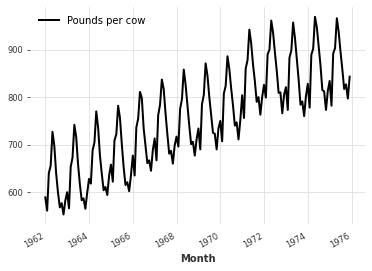

In [3]:
series = MonthlyMilkDataset().load()

print(series)
series.plot()

## Using a transformer: Rescaling a time series using `Scaler`.

Some applications may require your datapoints to be between 0 and 1 (e.g. to feed a time series to a Neural Network based forecasting model). This is easily achieved using the default `Scaler`, which is a wrapper around `sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))`.

In [4]:
scaler = Scaler()
rescaled = scaler.fit_transform(series)
print(rescaled)

<TimeSeries (DataArray) (Month: 168, component: 1, sample: 1)>
array([[[0.08653846]],

       [[0.01923077]],

       [[0.20913462]],

       [[0.24759615]],

       [[0.41826923]],

       [[0.34615385]],

       [[0.20913462]],

       [[0.11057692]],

       [[0.03605769]],

       [[0.05769231]],

...

       [[0.81490385]],

       [[0.84134615]],

       [[0.99278846]],

       [[0.92307692]],

       [[0.82451923]],

       [[0.73317308]],

       [[0.63461538]],

       [[0.65865385]],

       [[0.58653846]],

       [[0.69711538]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1962-01-01 1962-02-01 ... 1975-12-01
  * component  (component) <U1 '0'
Dimensions without coordinates: sample


This scaling can easily be inverted too, by calling `inverse_transform()`

In [5]:
back = scaler.inverse_transform(rescaled)
print(back)

<TimeSeries (DataArray) (Month: 168, component: 1, sample: 1)>
array([[[589.]],

       [[561.]],

       [[640.]],

       [[656.]],

       [[727.]],

       [[697.]],

       [[640.]],

       [[599.]],

       [[568.]],

       [[577.]],

...

       [[892.]],

       [[903.]],

       [[966.]],

       [[937.]],

       [[896.]],

       [[858.]],

       [[817.]],

       [[827.]],

       [[797.]],

       [[843.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1962-01-01 1962-02-01 ... 1975-12-01
  * component  (component) <U1 '0'
Dimensions without coordinates: sample


Note that the `Scaler` also allows to specify other scalers in its constructor, as long as they implement `fit()`, `transform()` and `inverse_transform()` methods on `TimeSeries` (typically scalers from `scikit-learn`)

## Another example : `MissingValuesFiller`

Let's look at handling missing values in a dataset.

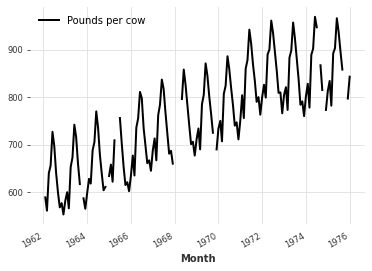

In [6]:
incomplete_series = MonthlyMilkIncompleteDataset().load()
incomplete_series.plot()

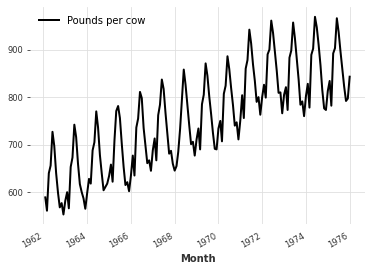

In [7]:
filler = MissingValuesFiller()
filled = filler.transform(incomplete_series, method="quadratic")

filled.plot()

Since `MissingValuesFiller` wraps around `pd.interpolate` by default, we can also provide arguments to the `pd.interpolate()` function when calling `transform()`

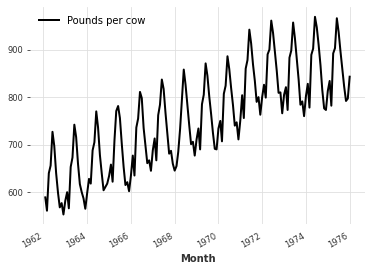

In [8]:
filled = filler.transform(incomplete_series, method="quadratic")
filled.plot()

## `Mapper` and `InvertibleMapper`: A special kind of transformers

Sometimes you may want to perform a simple `map()` function on the data. This can also be done using data transformers. `Mapper` takes in a function and applies it to the data elementwise when calling `transform()`.

`InvertibleMapper` also allows to specify an inverse function at creation (if there is one) and provides the `inverse_transform()` method.

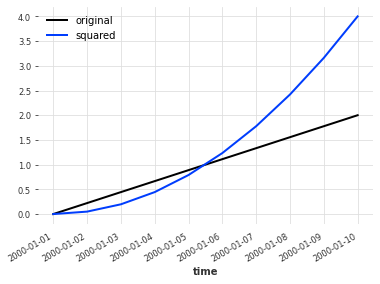

In [9]:
lin_series = linear_timeseries(start_value=0, end_value=2, length=10)

squarer = Mapper(lambda x: x**2)
squared = squarer.transform(lin_series)

lin_series.plot(label="original")
squared.plot(label="squared")
plt.legend()

### More complex (and useful) transformations

In the Monthly Milk Production dataset used earlier, some of the difference between the months comes from the fact that some months contain more days than others, resulting in a larger production of milk during those months. This makes the time series more complex, and thus harder to predict. 

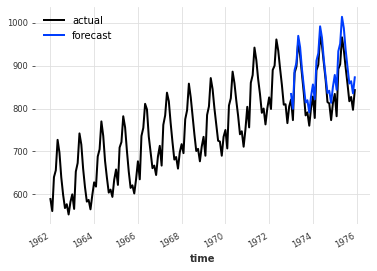

In [10]:
training, validation = series.split_before(pd.Timestamp("1973-01-01"))

model = ExponentialSmoothing()
model.fit(training)
forecast = model.predict(36)

plt.title("MAPE = {:.2f}%".format(mape(forecast, validation)))
series.plot(label="actual")
forecast.plot(label="forecast")
plt.legend()

To take this fact into account and achieve better performance, we could instead:

1. Transform the time series to represent the average daily production of milk for each month (instead of the total production per month)
2. Make a forecast
3. Inverse the transformation

Let's see how this would be implemented using `InvertibleMapper` and `pd.timestamp.days_in_month`

(Idea taken from ["Forecasting: principles and Practice"](https://otexts.com/fpp2/transformations.html) by Hyndman and Athanasopoulos)

To transform the time series, we have to divide a monthly value (the data point) by the number of days in the month given by the value's corresponding timestamp.

`map()` (and thus `Mapper` / `InvertibleMapper`) makes this convenient by allowing to apply a transformation function which uses both the value and its timestamp to compute the new value: `f(timestamp, value) = new_value`

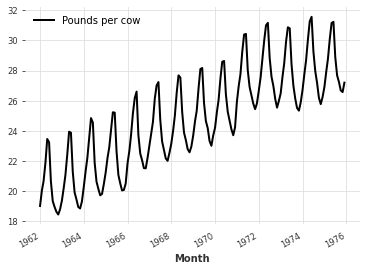

In [11]:
# Transform the time series
toDailyAverage = InvertibleMapper(
    fn=lambda timestamp, x: x / timestamp.days_in_month,
    inverse_fn=lambda timestamp, x: x * timestamp.days_in_month,
)

dailyAverage = toDailyAverage.transform(series)

dailyAverage.plot()

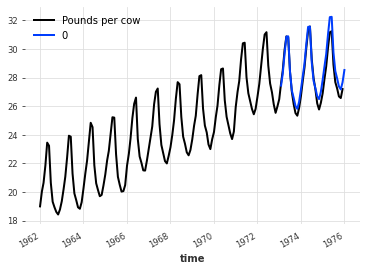

In [12]:
# Make a forecast
dailyavg_train, dailyavg_val = dailyAverage.split_after(pd.Timestamp("1973-01-01"))

model = ExponentialSmoothing()
model.fit(dailyavg_train)
dailyavg_forecast = model.predict(36)

plt.title("MAPE = {:.2f}%".format(mape(dailyavg_forecast, dailyavg_val)))
dailyAverage.plot()
dailyavg_forecast.plot()
plt.legend()

In [13]:
# Inverse the transformation
# Here the forecast is stochastic; so we take the median value
forecast = toDailyAverage.inverse_transform(dailyavg_forecast)

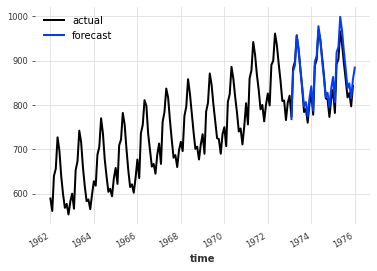

In [14]:
plt.title("MAPE = {:.2f}%".format(mape(forecast, validation)))
series.plot(label="actual")
forecast.plot(label="forecast")
plt.legend()

## Chaining transformations : introducing `Pipeline`

Now suppose that we both want to apply the above transformation (daily averaging), and rescale the dataset between 0 and 1 to use a Neural Network based forecasting model. Instead of applying these two transformations separately, and then inversing them separately, we can use a `Pipeline`.


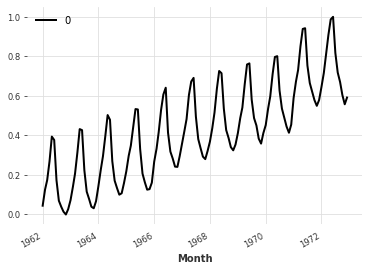

In [15]:
pipeline = Pipeline([toDailyAverage, scaler])
transformed = pipeline.fit_transform(training)
transformed.plot()

If all transformations in the pipeline are invertible, the `Pipeline` object is too.

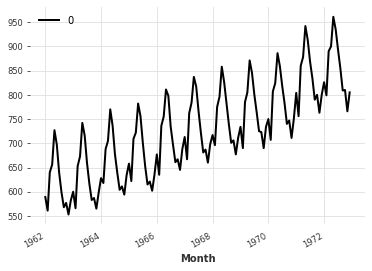

In [16]:
back = pipeline.inverse_transform(transformed)
back.plot()

Recall now the incomplete series from `monthly-milk-incomplete.csv`. Suppose that we want to encapsule all our preprocessing steps into a Pipeline, consisting of: a `MissingValuesFiller` for filling the missing values, and a `Scaler` for scaling the dataset between 0 and 1. 

In [17]:
incomplete_series = MonthlyMilkIncompleteDataset().load()

filler = MissingValuesFiller()
scaler = Scaler()

pipeline = Pipeline([filler, scaler])
transformed = pipeline.fit_transform(incomplete_series)

Suppose we have trained a Neural Network and produced some predictions. Now, we want to scale back out data. Unfortunately, since the `MissingValuesFiller` is not an `InvertibleDataTransformer` (why on Earth would someone want to insert missing values in the results!?), the inverse transformation will raise an exception: _ValueError: Not all transformers in the pipeline can perform inverse_transform_.

Frustrating right? Fortunately, you don't have to re-run everything from scratch, excluding the `MissingValuesFiller` from the `Pipeline`. Instead, you can just set the `partial` argument of the `inverse_transform` method to True. In this case, the inverse transformation will be performed skipping the not invertible transformers.

In [18]:
back = pipeline.inverse_transform(transformed, partial=True)

## Processing multiple TimeSeries

Often, we have to deal with multiple TimeSeries. DARTS supports Sequences of TimeSeries as input to transformers and pipelines, so that you don't have to take care of processing each sample separately. Furthermore, it will take care of storing the parameters used by each scaler while transforming different TimeSeries (e.g., with scalers).

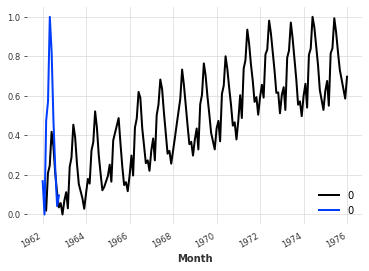

In [19]:
series = MonthlyMilkDataset().load()
incomplete_series = MonthlyMilkIncompleteDataset().load()

multiple_ts = [incomplete_series, series[:10]]

filler = MissingValuesFiller()
scaler = Scaler()

pipeline = Pipeline([filler, scaler])
transformed = pipeline.fit_transform(multiple_ts)

for ts in transformed:
    ts.plot()

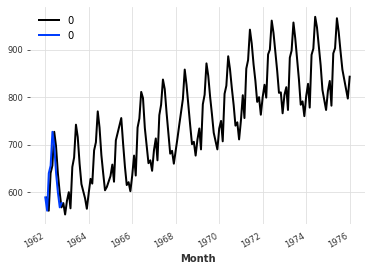

In [20]:
back = pipeline.inverse_transform(transformed, partial=True)
for ts in back:
    ts.plot()

## Monitoring & parallelising data processing

Sometimes, we could also have to deal with huge datasets. In this cases, processing each sample sequentially can take quite a long time. Darts can help both monitoring the transformations, and processing multiple samples in parallel, when possible. 

Setting the `verbose` parameter in each transformer or pipeline while create some progress bars:

In [21]:
series = MonthlyMilkIncompleteDataset().load()

huge_number_of_series = [series] * 10000

scaler = Scaler(verbose=True, name="Basic")

transformed = scaler.fit_transform(huge_number_of_series)

Fitting (Basic):   0%|          | 0/10000 [00:00<?, ?it/s]

Transform (Basic):   0%|          | 0/10000 [00:00<?, ?it/s]

We now know for how long we will have to wait. But since nobody loves wasting time waiting, we can leverage multiple cores of our machine to process data in parallel. We can do so by setting the `n_jobs` parameter (same usage as in `sklearn`). 

**Note**: the speed-up closely depends on the number of available cores and the 'CPU-intensiveness' of the transformation.

In [22]:
# setting n_jobs to -1 will make the library using all the cores available in the machine
scaler = Scaler(verbose=True, n_jobs=-1, name="Faster")
scaler.fit(huge_number_of_series)
back = scaler.transform(huge_number_of_series)

Fitting (Faster):   0%|          | 0/10000 [00:00<?, ?it/s]

Transform (Faster):   0%|          | 0/10000 [00:00<?, ?it/s]